In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.model_selection import RandomizedSearchCV
import time

from preprocessing import get_processed_data, load_and_clean_data, feature_engineering, time_series_split

pd.set_option('display.max_colwidth', None)

from xgboost import plot_importance

In [15]:
DATA_PATH = r'C:\Work folders\ML_Projects\Прогнозування продуктивності комбайнів\Погодинний_збір_пшениці.xlsx'

In [16]:
X_train, y_train, X_val, y_val, X_test, y_test, encoder = get_processed_data(DATA_PATH)

--- Розподіл даних ---
Train: 77726 рядків. Період: 2022-07-06 08:00:00 — 2025-07-31 23:00:00
Val:   11188 рядків.   Період: 2025-08-01 00:00:00 — 2025-08-14 23:00:00
Test:  4285 рядків.  Період: 2025-08-15 08:00:00 — 2025-08-27 23:00:00
Числові ознаки: ['Опади_мм', 'Сума_опадів_за_позавчора_мм', 'Сума_опадів_за_вчора_мм', 'Сума_опадів_за_ніч_мм', 'Сума_опадів_за_попередні_3_год_мм', 'Година']
Категорійні: ['Модель']
Цільова змінна: Зібрано_га


In [17]:
experiments_log = pd.DataFrame(columns=['Модель', 'Параметри', 'MAE', 'RMSE', 'Час тренування'])

In [18]:
def log_experiment(model_name, y_train, y_pred_train, y_val, y_pred_val, y_test, y_pred_test, params=None, training_time=None):
    """
    Додає результати (Train, Val, Test та час) в таблицю experiments_log
    """
    global experiments_log
    
    mae_train = mean_absolute_error(y_train, y_pred_train).__round__(2)
    rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train)).__round__(2)
    
    mae_val = mean_absolute_error(y_val, y_pred_val).__round__(2)
    rmse_val = np.sqrt(mean_squared_error(y_val, y_pred_val)).__round__(2)

    mae_test = mean_absolute_error(y_test, y_pred_test).__round__(2)
    rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test)).__round__(2)
    
    new_row_data = {
        'Модель': [model_name],
        'Параметри': [str(params)],
        'Train_MAE': [mae_train],
        'Train_RMSE': [rmse_train],
        'Val_MAE': [mae_val],
        'Val_RMSE': [rmse_val],
        'Test_MAE': [mae_test],
        'Test_RMSE': [rmse_test],
        'Час тренування, сек': [training_time if training_time is not None else np.nan],
        
    }
    
    new_row = pd.DataFrame(new_row_data)

    if experiments_log.empty:
         experiments_log = new_row
    else:
         experiments_log = pd.concat([experiments_log, new_row], ignore_index=True)
    
    print(f"{model_name}")
    if training_time:
        print(f"Час тренування: {training_time:.2f} сек.")
    print("-" * 30)
    print(f"MAE (train): {mae_train:.2f}")
    print(f"RMSE (train): {rmse_train:.2f}")
    print("-" * 30)
    print(f"MAE (validation): {mae_val:.2f}")
    print(f"RMSE (validation): {rmse_val:.2f}")
    print("-" * 30)
    print(f"MAE (test): {mae_test:.2f}")
    print(f"RMSE (test): {rmse_test:.2f}")
    print("-" * 30)

In [19]:
def train_single_model(model_class, model_name, params=None):
    """
    1. Створює модель з фіксованими параметрами.
    2. Тренує її на X_train.
    3. Оцінює на Train та Val.
    4. Логує результат.
    """
    
    if params is None:
        params = {}
    
    model = model_class(**params)
    
    start_time = time.time()
    
    model.fit(X_train, y_train)

    end_time = time.time()

    training_time = (end_time - start_time).__round__(2)
    
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)
    y_test_pred = model.predict(X_test)
    
    log_experiment(
        model_name, 
        y_train, 
        y_train_pred, 
        y_val, 
        y_val_pred,
        y_test, 
        y_test_pred, 
        params=params,
        training_time=training_time.__round__(2)
    )
    
    return model

In [20]:
dummy_params = {
    'strategy': 'mean'
}

rf_reg = train_single_model(DummyRegressor, "DummyRegressor", dummy_params)

DummyRegressor
------------------------------
MAE (train): 1.18
RMSE (train): 1.34
------------------------------
MAE (validation): 1.30
RMSE (validation): 1.51
------------------------------
MAE (test): 1.39
RMSE (test): 1.64
------------------------------


In [21]:
rf_params = {
    'n_estimators': 100,
    'max_depth': 10,
    'min_samples_split': 5,
    'min_samples_leaf': 2,
    'random_state': 17
}

rf_reg = train_single_model(RandomForestRegressor, "RandomForest", rf_params)

RandomForest
Час тренування: 7.68 сек.
------------------------------
MAE (train): 0.65
RMSE (train): 0.94
------------------------------
MAE (validation): 0.85
RMSE (validation): 1.16
------------------------------
MAE (test): 0.91
RMSE (test): 1.20
------------------------------


In [22]:
xgb_params = {
    'n_estimators': 100,
    'learning_rate': 0.1,
    'max_depth': 6,
    'random_state': 17,
    'verbosity': 0
}

xgb_reg = train_single_model(XGBRegressor, "XGBoost", xgb_params)

XGBoost
Час тренування: 0.31 сек.
------------------------------
MAE (train): 0.66
RMSE (train): 0.93
------------------------------
MAE (validation): 0.82
RMSE (validation): 1.10
------------------------------
MAE (test): 0.89
RMSE (test): 1.17
------------------------------


In [23]:
lgbm_params = {
    'n_estimators': 100,
    'learning_rate': 0.1,
    'max_depth': 6,
    'random_state': 17,
    'verbosity': -1
}

lgbm_reg = train_single_model(LGBMRegressor, "LightGBM", lgbm_params)

LightGBM
Час тренування: 0.20 сек.
------------------------------
MAE (train): 0.67
RMSE (train): 0.94
------------------------------
MAE (validation): 0.84
RMSE (validation): 1.10
------------------------------
MAE (test): 0.90
RMSE (test): 1.16
------------------------------


In [24]:
cb_params = {
    'iterations': 100,
    'learning_rate': 0.1,
    'depth': 6,
    'random_seed': 17,
    'verbose': 0
}

cb_reg = train_single_model(CatBoostRegressor, "CatBoost", cb_params)

CatBoost
Час тренування: 0.83 сек.
------------------------------
MAE (train): 0.72
RMSE (train): 0.99
------------------------------
MAE (validation): 0.84
RMSE (validation): 1.08
------------------------------
MAE (test): 0.89
RMSE (test): 1.14
------------------------------


In [25]:
def tune_and_evaluate(model_class, param_grid, model_name, n_iter=10):
    """
    1. Запускає RandomizedSearchCV для пошуку найкращих параметрів.
    2. Передає знайдені параметри у train_single_model для фінального навчання,
       оцінки (Train/Val/Test) та логування.
    """
    search = RandomizedSearchCV(
        estimator=model_class(),
        param_distributions=param_grid,
        n_iter=n_iter,
        scoring='neg_mean_absolute_error',
        cv=3,
        verbose=1,
        random_state=17,
        n_jobs=-1
    )
    
    search.fit(X_train, y_train)
    
    best_params = search.best_params_
    print(f"Найкращі параметри знайдено: {best_params}")
    print("-" * 30)
    
    final_model = train_single_model(
        model_class, 
        model_name, 
        params=best_params
    )
    
    return final_model

In [26]:
xgb_params = {
    'n_estimators': [300, 500, 700, 1000],
    'learning_rate': [0.005, 0.01, 0.03, 0.05, 0.1], 
    'max_depth': [3, 4, 5, 6, 8], 
    'min_child_weight': [1, 3, 5, 7, 10], 
    'gamma': [0, 0.1, 0.25, 0.5, 1, 2],
    'reg_alpha': [0, 0.1, 1, 5, 10],
    'reg_lambda': [0.1, 1, 5, 10, 50],
    'subsample': [0.6, 0.7, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 1.0],
    'random_state': [17]
}

best_xgb = tune_and_evaluate(XGBRegressor, xgb_params, "XGBoost + RandomSearch", n_iter=30)

Fitting 3 folds for each of 30 candidates, totalling 90 fits
Найкращі параметри знайдено: {'subsample': 0.7, 'reg_lambda': 50, 'reg_alpha': 0.1, 'random_state': 17, 'n_estimators': 500, 'min_child_weight': 3, 'max_depth': 3, 'learning_rate': 0.03, 'gamma': 1, 'colsample_bytree': 0.6}
------------------------------
XGBoost + RandomSearch
Час тренування: 2.14 сек.
------------------------------
MAE (train): 0.75
RMSE (train): 1.01
------------------------------
MAE (validation): 0.85
RMSE (validation): 1.08
------------------------------
MAE (test): 0.92
RMSE (test): 1.16
------------------------------


In [27]:
lgbm_params = {
    'num_leaves': [15, 20, 31, 40], 
    'max_depth': [3, 5, 7, 10],   
    'min_child_samples': [20, 40, 60, 100], 
    'reg_alpha': [0, 0.1, 1, 5, 10],
    'reg_lambda': [0, 1, 5, 10, 20],
    'subsample': [0.6, 0.7, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 1.0], 
    'learning_rate': [0.01, 0.03, 0.05, 0.1],
    'n_estimators': [200, 400, 600, 800],
    'random_state': [17]
}

class QuietLGBM(LGBMRegressor):
    def __init__(self, **kwargs):
        kwargs.pop('verbose', None)
        super().__init__(verbose=-1, **kwargs)

best_lgbm = tune_and_evaluate(QuietLGBM, lgbm_params, "LightGBM + RandomSearch", n_iter=50)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
Найкращі параметри знайдено: {'subsample': 0.8, 'reg_lambda': 1, 'reg_alpha': 1, 'random_state': 17, 'num_leaves': 31, 'n_estimators': 200, 'min_child_samples': 100, 'max_depth': 3, 'learning_rate': 0.05, 'colsample_bytree': 0.6}
------------------------------
LightGBM + RandomSearch
Час тренування: 0.34 сек.
------------------------------
MAE (train): 0.76
RMSE (train): 1.01
------------------------------
MAE (validation): 0.88
RMSE (validation): 1.15
------------------------------
MAE (test): 0.95
RMSE (test): 1.23
------------------------------


In [28]:
display(experiments_log)

,Модель,Параметри,Train_MAE,Train_RMSE,Val_MAE,Val_RMSE,Test_MAE,Test_RMSE,"Час тренування, сек"
0,DummyRegressor,{'strategy': 'mean'},1.18,1.34,1.30,1.51,1.39,1.64,0.00
1,RandomForest,"{'n_estimators': 100, 'max_depth': 10, 'min_samples_split': 5, 'min_samples_leaf': 2, 'random_state': 17}",0.65,0.94,0.85,1.16,0.91,1.20,7.68
2,XGBoost,"{'n_estimators': 100, 'learning_rate': 0.1, 'max_depth': 6, 'random_state': 17, 'verbosity': 0}",0.66,0.93,0.82,1.10,0.89,1.17,0.31
3,LightGBM,"{'n_estimators': 100, 'learning_rate': 0.1, 'max_depth': 6, 'random_state': 17, 'verbosity': -1}",0.67,0.94,0.84,1.10,0.90,1.16,0.20
4,CatBoost,"{'iterations': 100, 'learning_rate': 0.1, 'depth': 6, 'random_seed': 17, 'verbose': 0}",0.72,0.99,0.84,1.08,0.89,1.14,0.83
5,XGBoost + RandomSearch,"{'subsample': 0.7, 'reg_lambda': 50, 'reg_alpha': 0.1, 'random_state': 17, 'n_estimators': 500, 'min_child_weight': 3, 'max_depth': 3, 'learning_rate': 0.03, 'gamma': 1, 'colsample_bytree': 0.6}",0.75,1.01,0.85,1.08,0.92,1.16,2.14
6,LightGBM + RandomSearch,"{'subsample': 0.8, 'reg_lambda': 1, 'reg_alpha': 1, 'random_state': 17, 'num_leaves': 31, 'n_estimators': 200, 'min_child_samples': 100, 'max_depth': 3, 'learning_rate': 0.05, 'colsample_bytree': 0.6}",0.76,1.01,0.88,1.15,0.95,1.23,0.34


Пошук параметрів за допомогою RandomSearch не покращив метрики на валідаційному та тестовому наборах даних, але зменшив тршіки різницю з тренувальним набором. Тому візьмемо поки XGBoost з вручну обраними параметрами.

Аналіз помилок

In [29]:
df_raw = pd.read_excel(DATA_PATH)

df_raw = feature_engineering(df_raw)

_, val_df_raw, _ = time_series_split(df_raw)

print(f"Розмір валідаційного набору даних: {val_df_raw.shape}")

preds = xgb_reg.predict(X_val) 
val_df_raw['Прогноз_га'] = preds
val_df_raw['Помилка'] = val_df_raw['Зібрано_га'] - val_df_raw['Прогноз_га']
val_df_raw['Абс_Помилка'] = val_df_raw['Помилка'].abs()

display(val_df_raw[['date_time', 'Гаражний номер', 'Модель', 'Зібрано_га', 'Прогноз_га', 'Абс_Помилка']].head())

--- Розподіл даних ---
Train: 77726 рядків. Період: 2022-07-06 08:00:00 — 2025-07-31 23:00:00
Val:   11188 рядків.   Період: 2025-08-01 00:00:00 — 2025-08-14 23:00:00
Test:  4285 рядків.  Період: 2025-08-15 08:00:00 — 2025-08-27 23:00:00
Розмір валідаційного набору даних: (11188, 16)


,date_time,Гаражний номер,Модель,Зібрано_га,Прогноз_га,Абс_Помилка
64,2025-08-14 00:00:00,К-117,CLAAS LEXION 770,0.0,0.042126,0.042126
65,2025-08-14 01:00:00,К-117,CLAAS LEXION 770,0.0,0.042126,0.042126
66,2025-08-14 02:00:00,К-117,CLAAS LEXION 770,0.0,0.042126,0.042126
67,2025-08-14 03:00:00,К-117,CLAAS LEXION 770,0.0,0.042126,0.042126
68,2025-08-14 04:00:00,К-117,CLAAS LEXION 770,0.0,0.042126,0.042126


In [30]:
val_df_raw['Прогноз_га'].describe().round(2)

count    11188.00
mean         1.67
std          1.10
min         -0.33
25%          0.63
50%          1.89
75%          2.27
max          5.29
Name: Прогноз_га, dtype: float64

In [31]:
val_df_raw[val_df_raw['Прогноз_га'] < 0].shape

(241, 19)

Бачимо, що модель прогнозує продуктивність менше 0, що не коректно для цієї задачі. Прочитав, що можна спробувати параметр 'objective': 'reg:tweedie' для розподілів як у нас.

In [32]:
xgb_params = {
    'n_estimators': 1000,
    'learning_rate': 0.05,
    'max_depth': 2,
    'objective': 'reg:tweedie',
    'tweedie_variance_power': 1.1,
    'random_state': 17,
    'verbosity': 0
}

xgb_reg = train_single_model(XGBRegressor, "XGBoost (reg:tweedie)", xgb_params)

XGBoost (reg:tweedie)
Час тренування: 3.26 сек.
------------------------------
MAE (train): 0.70
RMSE (train): 0.99
------------------------------
MAE (validation): 0.80
RMSE (validation): 1.07
------------------------------
MAE (test): 0.86
RMSE (test): 1.13
------------------------------


In [33]:
df_raw = pd.read_excel(DATA_PATH)

df_raw = feature_engineering(df_raw)

_, val_df_raw, _ = time_series_split(df_raw)

print(f"Розмір валідаційного набору даних: {val_df_raw.shape}")

preds = xgb_reg.predict(X_val) 
val_df_raw['Прогноз_га'] = preds
val_df_raw['Помилка'] = val_df_raw['Зібрано_га'] - val_df_raw['Прогноз_га']
val_df_raw['Абс_Помилка'] = val_df_raw['Помилка'].abs()

display(val_df_raw[['date_time', 'Гаражний номер', 'Модель', 'Зібрано_га', 'Прогноз_га', 'Абс_Помилка']].head())

--- Розподіл даних ---
Train: 77726 рядків. Період: 2022-07-06 08:00:00 — 2025-07-31 23:00:00
Val:   11188 рядків.   Період: 2025-08-01 00:00:00 — 2025-08-14 23:00:00
Test:  4285 рядків.  Період: 2025-08-15 08:00:00 — 2025-08-27 23:00:00
Розмір валідаційного набору даних: (11188, 16)


,date_time,Гаражний номер,Модель,Зібрано_га,Прогноз_га,Абс_Помилка
64,2025-08-14 00:00:00,К-117,CLAAS LEXION 770,0.0,0.010967,0.010967
65,2025-08-14 01:00:00,К-117,CLAAS LEXION 770,0.0,0.002237,0.002237
66,2025-08-14 02:00:00,К-117,CLAAS LEXION 770,0.0,0.002237,0.002237
67,2025-08-14 03:00:00,К-117,CLAAS LEXION 770,0.0,0.002237,0.002237
68,2025-08-14 04:00:00,К-117,CLAAS LEXION 770,0.0,0.002237,0.002237


In [34]:
val_df_raw['Прогноз_га'].describe().round(2)

count    11188.00
mean         1.61
std          1.04
min          0.00
25%          0.59
50%          1.84
75%          2.29
max          4.93
Name: Прогноз_га, dtype: float64

Модель тепер не прогнозує мінусові значення і ручним підбором параметрів вдалося навіть трішки покращити метрики.

Відобразимо таблицю експериментів

In [35]:
display(experiments_log)

,Модель,Параметри,Train_MAE,Train_RMSE,Val_MAE,Val_RMSE,Test_MAE,Test_RMSE,"Час тренування, сек"
0,DummyRegressor,{'strategy': 'mean'},1.18,1.34,1.30,1.51,1.39,1.64,0.00
1,RandomForest,"{'n_estimators': 100, 'max_depth': 10, 'min_samples_split': 5, 'min_samples_leaf': 2, 'random_state': 17}",0.65,0.94,0.85,1.16,0.91,1.20,7.68
2,XGBoost,"{'n_estimators': 100, 'learning_rate': 0.1, 'max_depth': 6, 'random_state': 17, 'verbosity': 0}",0.66,0.93,0.82,1.10,0.89,1.17,0.31
3,LightGBM,"{'n_estimators': 100, 'learning_rate': 0.1, 'max_depth': 6, 'random_state': 17, 'verbosity': -1}",0.67,0.94,0.84,1.10,0.90,1.16,0.20
4,CatBoost,"{'iterations': 100, 'learning_rate': 0.1, 'depth': 6, 'random_seed': 17, 'verbose': 0}",0.72,0.99,0.84,1.08,0.89,1.14,0.83
5,XGBoost + RandomSearch,"{'subsample': 0.7, 'reg_lambda': 50, 'reg_alpha': 0.1, 'random_state': 17, 'n_estimators': 500, 'min_child_weight': 3, 'max_depth': 3, 'learning_rate': 0.03, 'gamma': 1, 'colsample_bytree': 0.6}",0.75,1.01,0.85,1.08,0.92,1.16,2.14
6,LightGBM + RandomSearch,"{'subsample': 0.8, 'reg_lambda': 1, 'reg_alpha': 1, 'random_state': 17, 'num_leaves': 31, 'n_estimators': 200, 'min_child_samples': 100, 'max_depth': 3, 'learning_rate': 0.05, 'colsample_bytree': 0.6}",0.76,1.01,0.88,1.15,0.95,1.23,0.34
7,XGBoost (reg:tweedie),"{'n_estimators': 1000, 'learning_rate': 0.05, 'max_depth': 2, 'objective': 'reg:tweedie', 'tweedie_variance_power': 1.1, 'random_state': 17, 'verbosity': 0}",0.70,0.99,0.80,1.07,0.86,1.13,3.26


Порівняємо також денний факт і прогноз

In [36]:
val_df_raw['Дата'] = val_df_raw['date_time'].dt.date

In [37]:
daily_stats = val_df_raw.groupby(['Дата', 'Гаражний номер', 'Модель'])[[
    'Зібрано_га', 
    'Прогноз_га'
]].sum().reset_index()

In [38]:
daily_stats['Помилка_День'] = daily_stats['Зібрано_га'] - daily_stats['Прогноз_га']

In [39]:
display(daily_stats)

,Дата,Гаражний номер,Модель,Зібрано_га,Прогноз_га,Помилка_День
0,2025-08-01,К-046,CLAAS LEXION 560,19.3,16.482737,2.817263
1,2025-08-01,К-078,CLAAS LEXION 670,6.8,19.761362,-12.961362
2,2025-08-01,К-082,CLAAS LEXION 670,3.4,5.722496,-2.322496
3,2025-08-01,К-083,CLAAS LEXION 670,34.3,21.806667,12.493333
4,2025-08-01,К-113,CLAAS LEXION 770,33.8,26.089220,7.710780
...,...,...,...,...,...,...
739,2025-08-14,К-177,CLAAS LEXION 8800 TT,48.7,44.069324,4.630676
740,2025-08-14,К-178,CLAAS LEXION 8800 TT,45.3,44.069324,1.230676
741,2025-08-14,К-179,CLAAS LEXION 8800 TT,39.3,44.069324,-4.769324
742,2025-08-14,К-180,CR 8.90,36.0,23.929102,12.070898


In [40]:
daily_stats[daily_stats['Гаражний номер'] == 'КБЗР-046'].round(2)

,Дата,Гаражний номер,Модель,Зібрано_га,Прогноз_га,Помилка_День


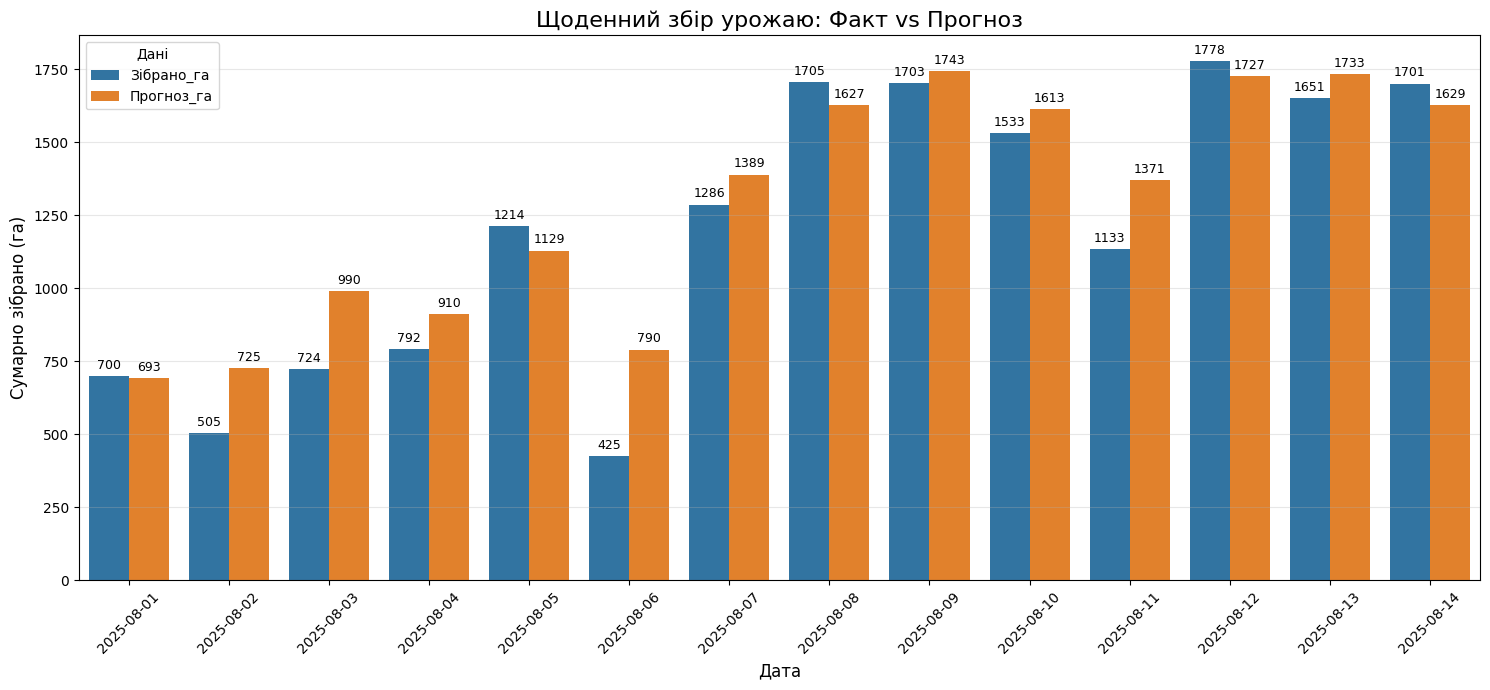

Сума гектарів по днях:


,Дата,Зібрано_га,Прогноз_га,"Різниця, га","Різниця, %"
0,2025-08-01,699.730995,692.772522,6.96,-0.99
1,2025-08-02,504.700000,725.380493,-220.68,43.73
2,2025-08-03,723.600000,990.089478,-266.49,36.83
3,2025-08-04,791.500000,910.174927,-118.67,14.99
4,2025-08-05,1213.890238,1128.785645,85.10,-7.01
5,2025-08-06,424.709762,789.935059,-365.23,85.99
6,2025-08-07,1286.100000,1388.981934,-102.88,8.00
7,2025-08-08,1705.029717,1626.858398,78.17,-4.58
8,2025-08-09,1702.670283,1742.551147,-39.88,2.34
9,2025-08-10,1532.530000,1613.291626,-80.76,5.27


In [41]:
total_daily_stats = val_df_raw.groupby('Дата')[['Зібрано_га', 'Прогноз_га']].sum().reset_index()

df_melted = total_daily_stats.melt(id_vars='Дата', 
                                   value_vars=['Зібрано_га', 'Прогноз_га'], 
                                   var_name='Тип', 
                                   value_name='Гектари')

plt.figure(figsize=(15, 7))

ax = sns.barplot(data=df_melted, x='Дата', y='Гектари', hue='Тип', palette=["#1f77b4", '#ff7f0e'])

for container in ax.containers:
    ax.bar_label(container, fmt='%.0f', padding=3, fontsize=9)

plt.title('Щоденний збір урожаю: Факт vs Прогноз', fontsize=16)
plt.ylabel('Сумарно зібрано (га)', fontsize=12)
plt.xlabel('Дата', fontsize=12)
plt.xticks(rotation=45)
plt.legend(title='Дані')
plt.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

total_daily_stats['Різниця, га'] = (total_daily_stats['Зібрано_га'] - total_daily_stats['Прогноз_га']).round(2)
total_daily_stats['Різниця, %'] = ((total_daily_stats['Прогноз_га'] - total_daily_stats['Зібрано_га']) / total_daily_stats['Зібрано_га'] * 100).round(2)
print("Сума гектарів по днях:")
display(total_daily_stats)

Бачимо, що у деякі дні модель спрогнозувала досить близькі значення до фактичного збору, але є дні з великою похибкою, особливо в ті де збирали менше

Вплив ознак

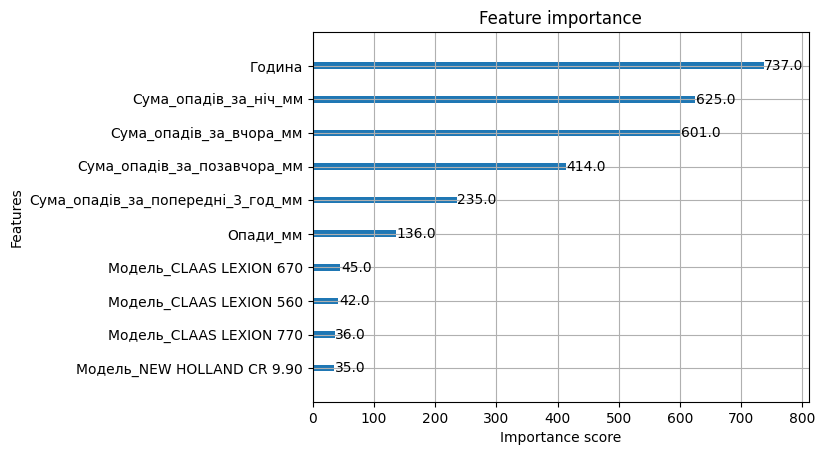

In [42]:
plot_importance(xgb_reg, max_num_features=10)
plt.show()

In [43]:
import joblib

In [44]:
joblib.dump(xgb_reg, 'xgb_reg_model.joblib')

['xgb_reg_model.joblib']

In [45]:
joblib.dump(encoder, 'encoder.joblib')

['encoder.joblib']